## Imports

In [1]:
import pandas as pd
import numpy as np

import sqlite3

import matplotlib.pyplot as plt
from ipyleaflet import Map, CircleMarker
import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson

import branca.colormap as cm

## Read and merge data

### Read from file

In [ ]:
sqlite_file = 'RaMBLE_playstore_v35.14_20200618_1344.sqlite'
sqlite_file = 'RaMBLE_playstore_v35.14_20200619_2149.sqlite'

# Create your connection.
cnx = sqlite3.connect(sqlite_file)
cur = cnx.cursor()

# Get all tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
available_tables=(cur.fetchall())

print(f'Tables available in DB: \n\t {available_tables}')

In [ ]:
# Read devices table
df_dev = pd.read_sql_query("SELECT * FROM devices", cnx)
df_dev = df_dev.drop('raw_adv_data', 1)
print(df_dev.shape)
df_dev.head()

In [ ]:
# Read locations table
df_loc = pd.read_sql_query("SELECT * FROM locations", cnx)
df_loc = df_loc.drop(['id'], 1)

print(df_loc.shape)
df_loc.head()

### Merge tables and filter

In [ ]:
# Join devices and connections
df = pd.merge(df_loc, df_dev, left_on='device_id', right_on='id', how='inner').drop('id', 1)
df = df.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'timestamp': 'dtg'})
df['dtg'] = pd.to_datetime(df.dtg, unit='s')
df = df.set_index('dtg')
df = df.assign(total_seen=lambda x: x.last_seen - x.first_seen)

# Filter CWA related connections
df_cwa = df[df.service_uuids == 'fd6f']

df_cwa.head()

In [ ]:
# Export data to CSV
start, end = '2020-06-19T1230', '2020-06-19T1630'
df_cwa.loc[start:end].to_csv('cwa_data_merged_cleaned.csv')

In [2]:
# Import data to CSV
df_cwa = pd.read_csv('cwa_data_merged_cleaned.csv', index_col=0, parse_dates=[0])

## Preprocess data
- Count unique devices in given time window

In [3]:
def group_timewindow(df, freq):
    df_grouped = []
    grouper = pd.Grouper(level='dtg', freq=freq, label='left')
    for i, grp in df.groupby(grouper):
        elem = {'dtg': i, 
                'n_devices': len(grp.device_id.unique()), 
                'n_sigthings': len(grp.device_id),
                'lat': grp.lat.mean(), 
                'lon': grp.lon.mean()}
        df_grouped.append(elem)

    df_grouped = pd.DataFrame(df_grouped).set_index('dtg')
    return df_grouped

df_res = group_timewindow(df_cwa, '2Min')
df_res.head(10)

,lat,lon,n_devices,n_sigthings
dtg,,,,
2020-06-19 12:40:00,51.362907,7.460612,9,9
2020-06-19 12:42:00,51.362907,7.460612,10,109
2020-06-19 12:44:00,51.362907,7.460612,12,111
2020-06-19 12:46:00,51.434478,7.547722,13,114
2020-06-19 12:48:00,51.485826,7.586846,15,114
2020-06-19 12:50:00,51.514010,7.633101,12,110
2020-06-19 12:52:00,51.537122,7.674216,12,78
2020-06-19 12:54:00,51.571315,7.735162,9,30
2020-06-19 12:56:00,51.593027,7.748541,10,45


In [4]:
#import math
#rssi=85
#tx=12
#math.pow(10, (tx-rssi)/(10*2))

## Visualization
### Timeline

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10f96a7b8>], dtype=object)

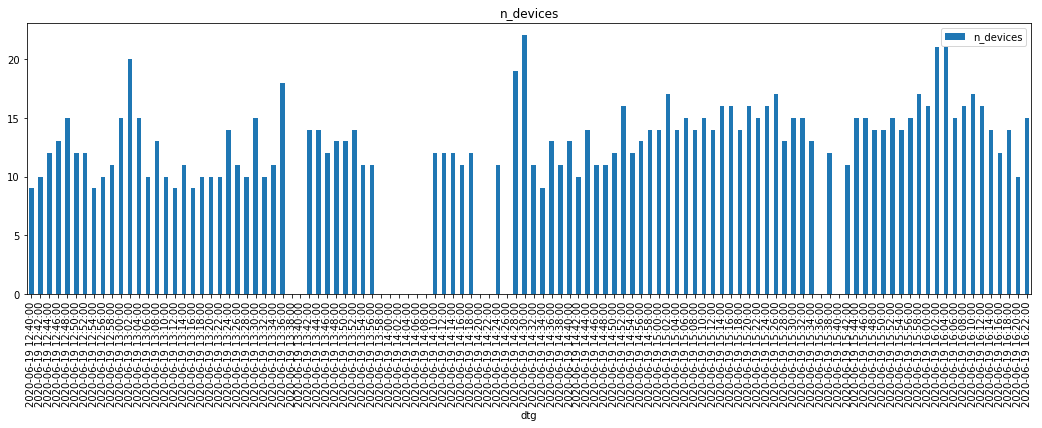

In [5]:
#start, end = '2020-06-18T0800', '2020-06-18T2100'
start, end = '2020-01-19T1000', '2020-09-19T2000'
df_res.loc[start:end, ['n_devices']].plot.bar(subplots=True, figsize=(18, 5))

### Signal strength

Text(0,0.5,'n')

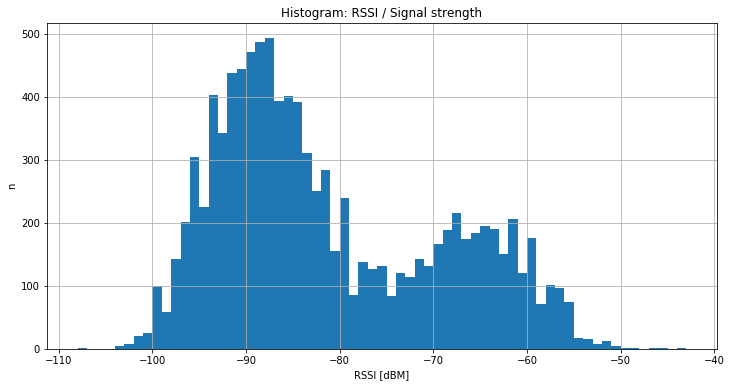

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
df_cwa.rssi.hist(bins=65, ax=ax)
ax.set_title('Histogram: RSSI / Signal strength')
ax.set_xlabel('RSSI [dBM]')
ax.set_ylabel('n')

### Device time

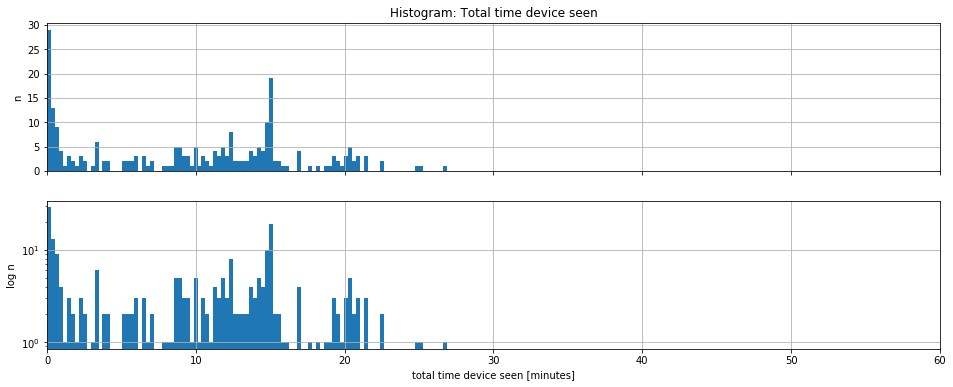

In [7]:
fig, axes = plt.subplots(figsize=(16,6), nrows=2, sharex=True)
ax = axes[0]
df_cwa.groupby('device_id').max().total_seen.div(60).hist(bins=101, ax=ax)
ax.set_title('Histogram: Total time device seen')
ax.set_ylabel('n')
ax.set_xlim(0,60)

ax = axes[1]
plt.yscale('log', nonposy='clip')
df_cwa.groupby('device_id').max().total_seen.div(60).hist(bins=101, ax=ax)
ax.set_ylabel('log n')
ax.set_xlabel('total time device seen [minutes]');

### Packets recieved

Text(0,0.5,'n sightings')

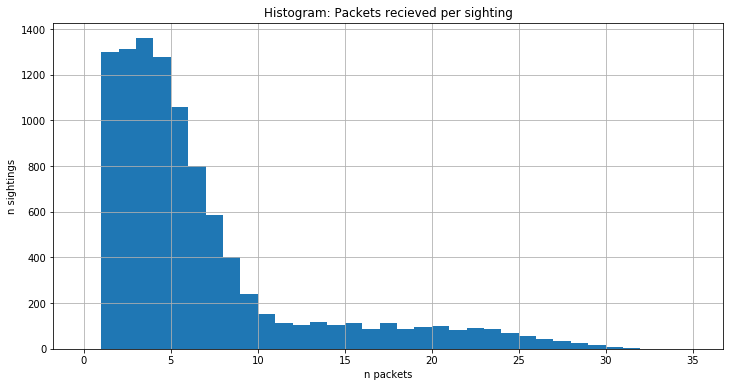

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
df_cwa.packets_received.hist(bins=35, ax=ax)
ax.set_title('Histogram: Packets recieved per sighting')
ax.set_xlabel('n packets')
ax.set_ylabel('n sightings')

## Map visualization
### Prepare maps

In [9]:
def create_geojson_features(df, colormap):
    geojson = []
    for ind, row in df.iterrows():
        color = colormap(row.n_devices)
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['lon'], row['lat']]
            },
            'properties': {
                'time': row.dtg.__str__(),
                'style': {'color': color},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': color,
                    'fillOpacity': 1,
                    'stroke': 'true',
                    'radius': 3
                }
            }
        }
        geojson.append(feature)
    geojson = {'type': 'FeatureCollection',
               'features': geojson}
    return geojson

In [10]:
def draw_geojson_time_map(geojson, colormap):
    center_lat, center_lon = get_geojson_coord_first(geojson)
    this_map = folium.Map(location=[center_lon, center_lat],
                          control_scale=True,
                          zoom_start=7,
                          tiles='cartodbpositron')
    
    TimestampedGeoJson(geojson,
                       period='PT15M',
                       #duration='PT15M',
                       transition_time=2000,
                       add_last_point=True,
                       auto_play=False,
                       loop=False,
                       max_speed=5,
                       #default_speed=5,
                       loop_button=True,
                       date_options='YYYY/MM/DD HH:mm',
                       time_slider_drag_update=True
                      ).add_to(this_map)
    this_map.add_child(colormap)
    
    return this_map

def get_geojson_coord_center(geojson):
    center_lat=np.mean([x['geometry']['coordinates'][0] for x in geojson['features']])
    center_lon=np.mean([x['geometry']['coordinates'][1] for x in geojson['features']])
    return center_lat, center_lon

def get_geojson_coord_first(geojson):
    return geojson['features'][0]['geometry']['coordinates']

### Map

In [11]:
start, end = '2020-06-19T1230', '2020-06-19T1630'

df_mapdata = df_res.loc[start:end].dropna().reset_index()

# Create colormap
val_max = df_mapdata.n_devices.max()
colors = ['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f']
#sns.palplot(sns.color_palette(colors))
colormap = cm.LinearColormap(colors=colors, vmin=0, vmax=val_max)

# Create Geojson
geojson = create_geojson_features(df_mapdata, colormap)

# Draw map
m = draw_geojson_time_map(geojson, colormap)

m

In [12]:
m.save('map.html')

In [ ]:
#start, end = '2020-06-19T1455', '2020-06-19T1515'
#start, end = '2020-06-19T1530', '2020-06-19T1545'
#start, end = '2020-06-19T1750', '2020-06-19T1810'
#df_res.loc[start:end, ['n_devices']]#.plot(kind='bar')

In [ ]:
#from ipywidgets import HTML
#from ipyleaflet import Map, Marker, Popup
#
#center = (df.Latitude.mean(), df.Longitude.mean())
#m = Map(center=center, zoom=15)
#
#for i, row in df.iterrows():
#    circle_marker = CircleMarker()
#    circle_marker.location = (row.Latitude, row.Longitude)
#    circle_marker.radius = 1
#    circle_marker.title = "my tooltip text"
#    #circle_marker.color = colors1[row.Device]
#    m.add_layer(circle_marker);
#    
#    message = HTML()
#    message.value = f'Device {str(row.Device)}'
#    #message2.placeholder = "Some HTML"
#    #message2.description = "Some HTML"
#    circle_marker.popup = message
#    
#m